In [1]:
!pip install -q --upgrade datasets[vision] opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 3.8 MB/s eta 0:00:00
ERROR: pip's depende

# Download Repo

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
from tqdm import trange, tqdm
import os

os.makedirs('/content/images/', exist_ok=True)
os.makedirs('/content/images/test', exist_ok=True)
os.makedirs('/content/images/train', exist_ok=True)

!cp -r --no-clobber /content/drive/MyDrive/arm-unicef/train/*.jpeg /content/images/train

local_dir = '/content'
drive_dir_train = '/content/drive/MyDrive/arm-unicef/train/'


# Count images in repo

In [4]:
try:
  train_files = os.listdir(f'{local_dir}/images/train')
  test_files = os.listdir(f'{local_dir}/images/test')
except:
  pass


print(f'Number of files in train folder: {len(train_files)}')
print(f'Number of files in train folder: {len(test_files)}')

Number of files in train folder: 4772
Number of files in train folder: 0


In [5]:
import glob


train_images = glob.glob(f'{local_dir}/images/train/*.jpeg')
test_images = glob.glob(f'{local_dir}/images/test/*.jpeg')

# Load HuggingFace Full Feature Dataset

In [6]:
from datasets import load_dataset

full_ds = load_dataset('mcarthuradal/arm-unicef', split='train' )
full_ds

Generating train split:   0%|          | 0/4772 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_rows: 4772
})

## To pandas

In [7]:
full_df = full_ds.to_pandas()
full_df = full_df.set_index('image_id')
full_df.image = full_df.image.str.replace('tif','jpeg')
full_df.head()

,image,width,height,objects
image_id,,,,
id_w55q2qr62fsk,id_w55q2qr62fsk.jpeg,500,500,"{'area': [1260, 1980, 990, 754, 2376, 1680, 74..."
id_fvldv7o1kn9d,id_fvldv7o1kn9d.jpeg,1000,1000,"{'area': [5180, 4392, 5644, 3795, 3900, 2208, ..."
id_5d1r9l1jp7b5,id_5d1r9l1jp7b5.jpeg,1000,1000,"{'area': [3132, 4225, 2960, 2907, 2860, 3828, ..."
id_45qru79t6s4n,id_45qru79t6s4n.jpeg,500,500,"{'area': [2464, 1645, 1520, 1804, 2200, 3551, ..."
id_84cjf2pbqmtv,id_84cjf2pbqmtv.jpeg,1000,1000,"{'area': [3422, 3481, 5846, 4012, 2420, 6699, ..."


# Draw Sample Image Bboxes


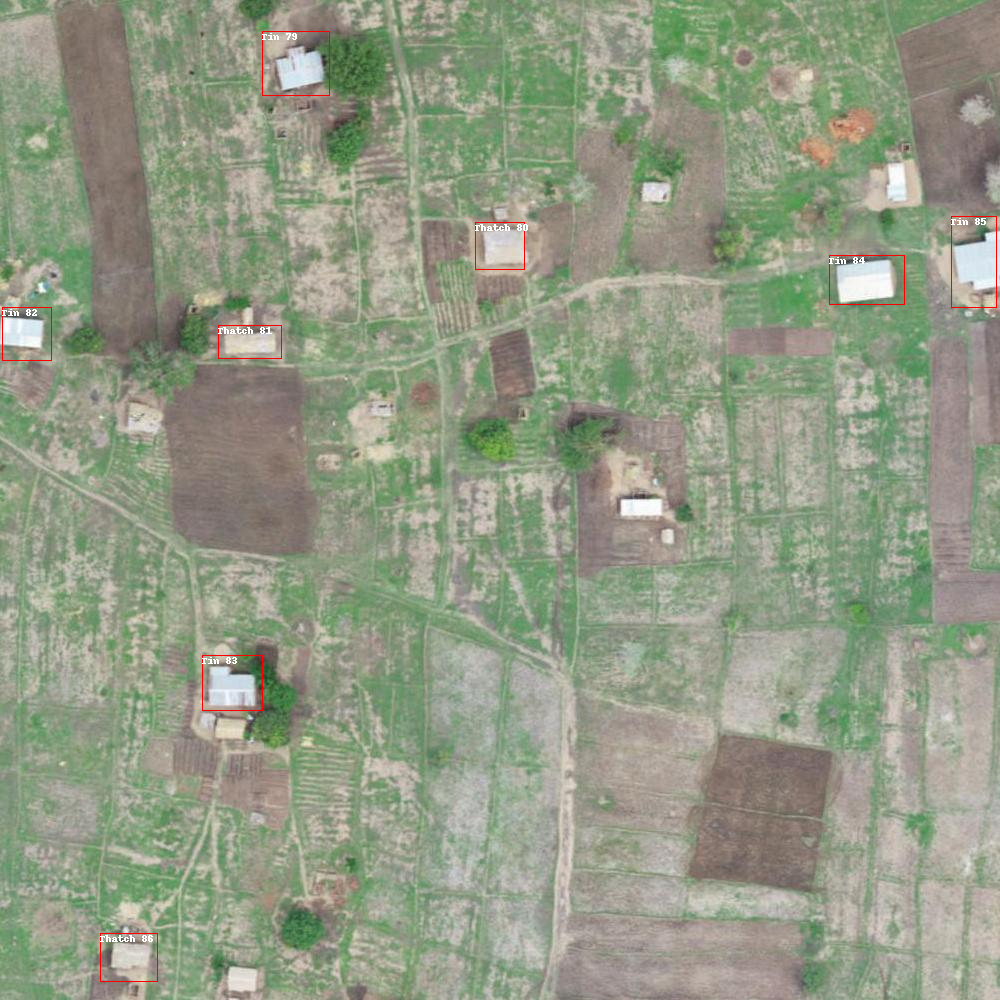

In [8]:
import numpy as np
from PIL import Image, ImageDraw

train_repo = f'{local_dir}/images/train'


def draw_bbox(image_file: str):
    path = ''
    if not image_file.endswith('.jpeg'):
      path = os.path.join(train_repo, image_file + '.jpeg')
    else:
      path = os.path.join(train_repo, image_file)
    image = Image.open(path)
    image_id =  image_file.rstrip('.jpeg')
    row = full_df.loc[image_id]
    draw = ImageDraw.Draw(image)

    objects = row["objects"]
    categories = objects["category"]

    id2label = {
        '0': 'no object',
        '1': 'Other',
        '2': 'Tin',
        '3': 'Thatch'
    }
    label2id = {v: k for k, v in id2label.items()}

    for i in range(len(objects['bbox'])):
        box = objects["bbox"][i]
        annot_id = objects["id"][i]
        class_idx = str(objects["category"][i])
        x, y, w, h = tuple(box)
        # Check if coordinates are normalized or not
        # if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)

        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x, y), id2label[class_idx]+f' {annot_id}', fill="white")
    return image

draw_bbox('id_0ih0rng01ntz')

# Check GPU

In [9]:
# prompt: check gpu

!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


# Transform bbox arrays to simple numpy arrays

In [10]:
test = full_df.copy(deep=True)
objects = test.iloc[0]['objects']

def to_numpy(objects):
  boxes = objects['bbox']
  categories = objects['category']

  b = []
  for box in boxes:
    a = [int(coord) for coord in box]
    b.append(a)

  new_boxes = np.array(b)



  new_categories = np.array(categories, dtype=np.int64)


  objects['bbox'] = new_boxes
  objects['category'] = new_categories
  return objects

to_numpy(objects)

{'area': array([1260, 1980,  990,  754, 2376, 1680,  748,  672,  999, 3450,  700,
         896,  924, 1764, 2499, 1050, 1216, 2107, 2100, 1326,  899, 1116,
        3538, 1443, 1287, 1443, 1400,  840, 1890, 1824, 2304, 1089,  810,
         700, 1120,  475, 1677,  960]),
 'bbox': array([[122,   1,  42,  30],
        [218, 112,  45,  44],
        [ 74, 286,  33,  30],
        [469, 182,  29,  26],
        [409, 444,  44,  54],
        [307, 311,  48,  35],
        [  0, 184,  22,  34],
        [164, 370,  28,  24],
        [454, 351,  37,  27],
        [ 51, 405,  46,  75],
        [472, 302,  25,  28],
        [344,  71,  28,  32],
        [266, 439,  33,  28],
        [172, 458,  49,  36],
        [ 16,  93,  49,  51],
        [108, 352,  35,  30],
        [101, 268,  38,  32],
        [456, 401,  43,  49],
        [131, 414,  50,  42],
        [269, 385,  39,  34],
        [183, 396,  29,  31],
        [116, 440,  31,  36],
        [120, 121,  61,  58],
        [124, 238,  39,  37],
  

In [11]:
try:
  full_df.objects = full_df.objects.apply(to_numpy)
except TypeError:
  pass

## Init ResNet (no FPN)

In [12]:
import torchvision
import torch.nn as nn

In [13]:
# Load the ResNet50 model with ImageNet weights
backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
backbone.fc

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 33.0MB/s]


Linear(in_features=2048, out_features=1000, bias=True)

In [14]:
# Get the number of features from the last layer
num_features = backbone.fc.in_features

# Replace the last fully-connected layer
backbone.fc = nn.Linear(512, 4)
backbone.out_channels = 512
backbone.fc

Linear(in_features=512, out_features=4, bias=True)

In [15]:
backbone.layer4

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

# Things to visualize


*  activation maximization,
* gradient-based methods, and
* occlusion sensitivity.  



In [16]:
import cv2
import matplotlib.pyplot as plt

from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import v2
import random
import glob

# drive_dir = '/content/drive/MyDrive/arm-unicef'

# train_images = glob.glob(f'{drive_dir}/train/*.jpeg')

random_image = random.sample(train_images, 1)

# input = read_image(f"{random_image[0]}")

# baseline = torch.zeros_like(input)

# to_pil_image(input)

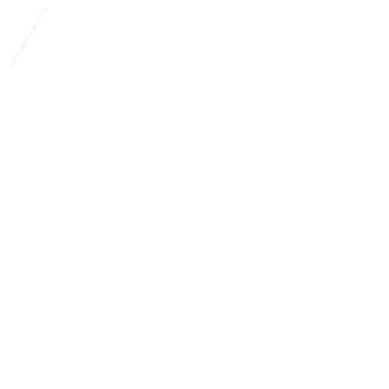

In [17]:
image = cv2.imread(random_image[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(image)

In [33]:
import torch
import torchvision.models as models
import math
from collections import OrderedDict

# Set the model to evaluation mode
backbone.eval()

preprocess = v2.Compose([
    # v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

def plot_fmaps(backbone):
  # Pass the input through the model to obtain feature maps
  with torch.no_grad():

    features = backbone.conv1(input_batch)
    features = backbone.bn1(features)
    features = backbone.relu(features)
    features = backbone.maxpool(features)
    features = backbone.layer1(features)
    features = backbone.layer2(features)
    features = backbone.layer3(features)
    features = backbone.layer4(features)


  shape = features.shape
  channels = features.shape[1]
  rows = math.ceil(math.sqrt(channels))
  cols = math.ceil(channels / rows)
  print(shape)

  plt.figure(figsize=(15, 15))
  for i in range(channels):  # Display feature maps from the first three channels
  # for i in range(20):  # Display feature maps from the first three channels
      plt.subplot(rows, cols, i + 1)
      # plt.subplot(4, 5, i + 1)
      # plt.title(f'{i+1}')
      plt.imshow(features[0, i].cpu().numpy(), cmap='viridis')
      plt.axis('off')
  plt.show()

plot_fmaps(backbone)

AttributeError: 'str' object has no attribute 'unsqueeze'

# plot heatmaps for activation maps

In [19]:
# Define hooks to capture activation maps
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def plot_activation_maps(model):
# Register hooks on selected layers
  layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
  for name in layer_names:
      getattr(model, name).register_forward_hook(get_activation(name))


  # Pass the input through the model
  with torch.no_grad():
      model(input_batch)

  # Visualize activation maps
  plt.figure(figsize=(15, 15))
  for i, name in enumerate(layer_names):
      activation_map = activation[name][0].mean(dim=0)  # Average along the channel dimension
      plt.subplot(1, len(layer_names), i + 1)
      plt.title(name)
      plt.imshow(activation_map.cpu(), cmap='viridis')
      plt.axis('off')
  plt.show()

plot_activation_maps(backbone)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2048 and 512x4)

# Init Faster RCNN

In [20]:
from torchvision.io.image import read_image
from torchvision.models.detection import (fasterrcnn_resnet50_fpn,
                                          fasterrcnn_resnet50_fpn_v2,
                                          FasterRCNN_ResNet50_FPN_Weights,
                                          FasterRCNN_ResNet50_FPN_V2_Weights)

from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

## prompt: load faster rcnn model from state dict


model_path = '/content/drive/MyDrive/arm-unicef/models'

frcnn = fasterrcnn_resnet50_fpn(weights=None,
                                weights_backbone=None,
                                num_classes= 4,
                                max_size = 1000,
                                min_size= 500,
                                skip_resize = True,
                                  #  trainable_backbone_layers=1,
                                rpn_pre_nms_top_n_train=1000,
                                  #  rpn_pre_nms_top_n_test=50,
                                rpn_post_nms_top_n_train=500,
                                rpn_post_nms_top_n_test=50,)

# Load the state dictionary from a file
state_dict = torch.load(f'{model_path}/trained_model.pth')

# Update the model's state dictionary with the loaded one
frcnn.load_state_dict(state_dict)
frcnn.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(500,), max_size=1000, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [32]:
import torch
import torchvision.models as models
import math
from collections import OrderedDict

# Set the model to evaluation mode
backbone.eval()

preprocess = v2.Compose([
    # v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

def plot_fmaps(backbone, n ):

  fmaps_dict = backbone(input_batch)


  features: torch.Tensor =  [f for _, f in fmaps_dict.items()]
  shape = features[n].shape
  channels = features[n].shape[1]
  rows = math.ceil(math.sqrt(channels))
  cols = math.ceil(channels / rows)
  print(shape)

  plt.figure(figsize=(15, 15))
  for i in range(channels):
      plt.subplot(rows, cols, i + 1)
      plt.imshow(features[n][0, i].detach().numpy(), cmap='viridis')
      plt.axis('off')
  plt.show()

plot_fmaps(frcnn.backbone, 4)


AttributeError: 'str' object has no attribute 'unsqueeze'

# Initialize and test Faster R-CNN Model

/content/images/train/id_db7ba03dzf67.jpeg


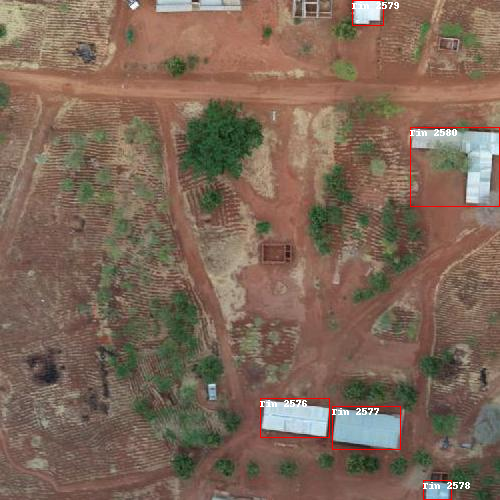

In [30]:


import random

random_image = random.sample(train_images, 1)

for image in random_image:
    print(image)


draw_bbox(random_image[0].split('/')[-1])


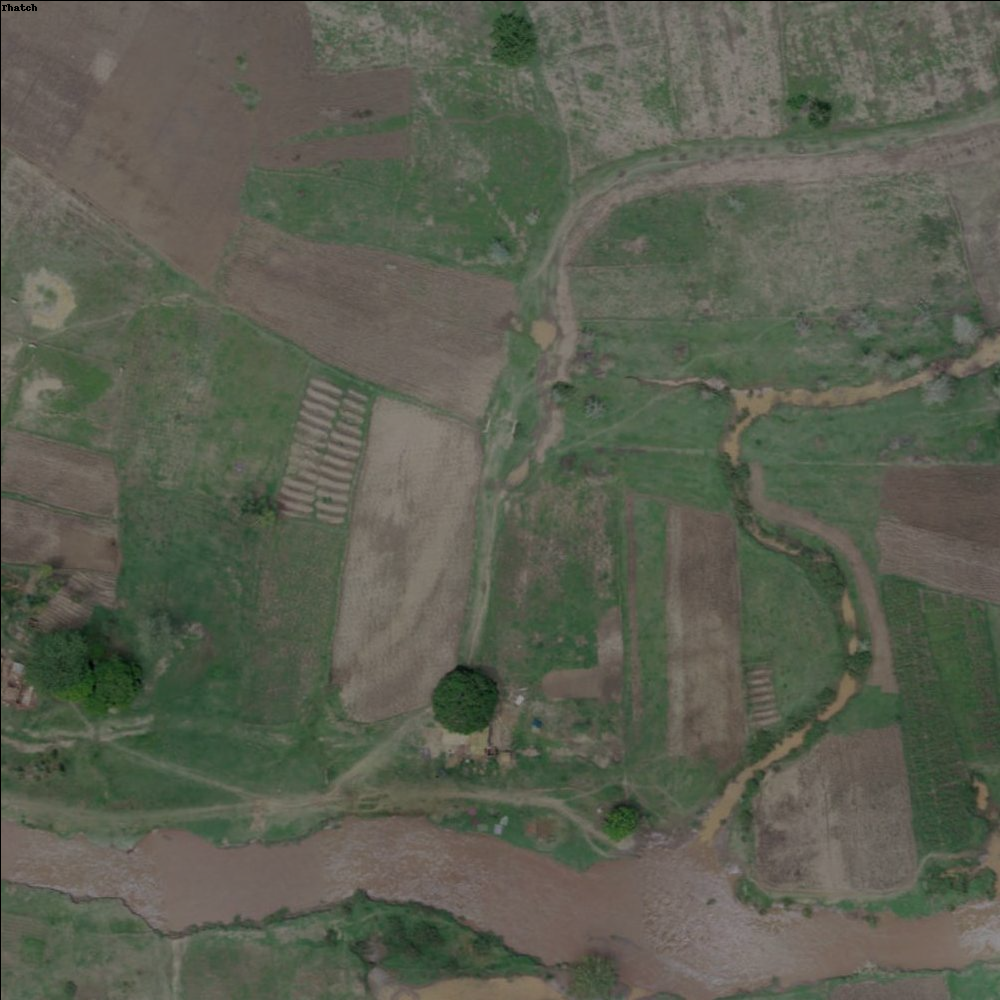

In [29]:
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

input = read_image(random_image[0])

img = to_pil_image(input)

frcnn.eval()

# Step 2: Initialize the inference v2
preprocess = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



# Step 3: Apply inference preprocessing v2
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = frcnn(batch)[0]
idx = prediction["labels"].tolist()
boxes = prediction["boxes"]

labels = []

for label in idx :
  id2label = {
        0: 'no object',
        1: 'Other',
        2: 'Tin',
        3: 'Thatch'
    }
  labels.append(id2label[label])
to_pil_image(draw_bounding_boxes(input,boxes=boxes,labels=labels, fill=True))


In [ ]:
prediction

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load pre-trained Faster R-CNN model with ResNet50 backbone
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# Set the model to evaluation mode
model.eval()

# Load and preprocess an example image
image_path = 'path/to/your/image.jpg'
image = Image.open(random_image[0]).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((800, 800)),  # Resize to the input size expected by the model
    transforms.ToTensor(),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Pass the input through the model to obtain RPN proposals and scores
with torch.no_grad():
    output = model(input_batch)
    proposals = output[0]['boxes']
    objectness_scores = output[0]['objectness_logits']

# Visualize the RPN proposals and objectness scores
plt.figure(figsize=(10, 10))
plt.imshow(image)
for i in range(min(100, len(proposals))):  # Visualize up to 100 proposals
    x1, y1, x2, y2 = proposals[i].cpu().numpy().tolist()
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color='red', linewidth=0.5)
    plt.text(x1, y1, f'{objectness_scores[i].item():.2f}', color='red', fontsize=8, backgroundcolor='white')
plt.axis('off')
plt.show()
